This workbook will show how calculate a boozer transform on several surfaces and then make a plot of the dominant modes.  There are no needs for input files, or calls to fortran codes for this calculation, everything is inside the VMEC package.

Note if you have not done the iotaplots workbook, you will need to install the packages in the first box of that workbook before doing this one.

In [29]:
using PlasmaEquilibriumToolkit
using VMEC
using NetCDF
using Plots
using LinearAlgebra

wout = NetCDF.open("C:/Users/Aaron/Documents/work/configs/wout_aten_a3b25.nc");
vmec, vmecdata = VMEC.readVmecWout(wout);

We will calculate the boozer spectrum for 10 different flux surfaces and plot the 10 largest modes (at core, at mid radius and at edge)  First generate an empty array to store stuff in.  This is the fullbmn.

We take advantage of Julia's free type casting here by making the "fullbmn" a 9 length vector of any object type. If you knew exactly the format of the output of boozerCosineSpectru, you could specify this and you would experience a speed up in the storage and retrieval from the fullbmn vector.  However, for this calculation, speed is not a concern.

The call to boozerCosineSpectrum outputs an array of the bmn values given a vmecSurface and a user specified values of m and n.  Here we choose 12 and 12 but you should try setting mb and nb to different numbers and seeing if the results change significantly.

The first variable that is passed is a symbol variable, this tells the boozerCosineSpectrum what to output (I think, make Ben explain)

In [30]:
mb = 12;
nb = 12;
#nmn = 2*mn*(nb-1) + nb; #this calculation is a little bizarre
fullbmn = Vector{Any}(undef,9)
for si in 1:9
    s = si/10;
    vmecSurface = VmecSurface(s, vmec);
    fullbmn[si] = VMEC.boozerCosineSpectrum(:bmn, vmecSurface, mb, nb);
end

We want to find and plot the 10 largest modes at s=0.5

The first section of the code extracts the s=0.5 value from the fullbmn array. Then it is sorted by the absolute value of the magnitude of the boozer coefficient, with the largest modes coming first.

The calculation to extract the magnitudes for each of the 10 modes at each of the 10 surfaces is written out explicitly in for loops. A label is created for each one, and the values are plotted.

You should also try to remove the largest mode (the 0,0 mode) by setting the outermost for loop to run from 2:10 instead of 1:10.  Depending on what equilibrium you have used, you may see signatures of quasisymmetry in the Boozer spectrum.

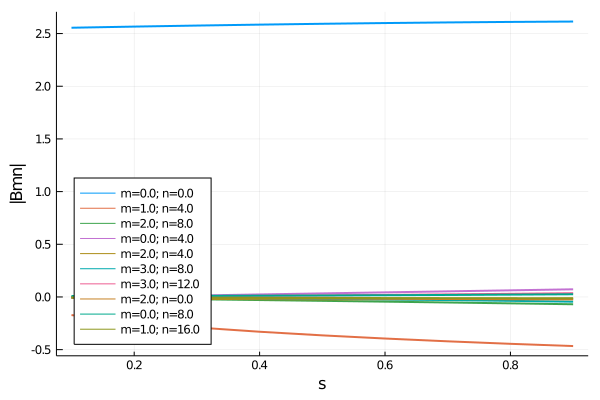

In [31]:
bmn5 = fullbmn[5];
sortIndices = sortperm(bmn5, by = x->abs(x[3]), rev=true);
firstPlot = true


for bi in 1:10
    bl = Vector{Float64}(undef, 9);
    for si in 1:9
        bl[si] = fullbmn[si][sortIndices[bi]][3];
    end
    m = fullbmn[1][sortIndices[bi]][1];
    n = fullbmn[1][sortIndices[bi]][2];
    slabel = "m="*string(m)*"; n="*string(n) #note julia uses * for string concatenation
    if firstPlot
        plot(0.1:0.1:0.9, bl, linewidth=2, label=slabel);
        firstPlot = false
    else
        plot!(0.1:0.1:0.9,bl, linewidth=2, label=slabel);
    end
end
plot!(legend=:bottomleft, xaxis="s", yaxis="|Bmn|")

One of the main reasons for calculating the boozer spectrum (for optimization purposes) is to calculate a metric for quasisymmetry.  We will calculate it for 9 values and then plot the quasisymmetry metric as a function of S.  

For the function to calculate the quasisymmetry it needs to know what the symmetric modes are.  For this example, we use a 4 field period quasihelically symmetric configuration.  So we set mqs to 1 and nqs to 4.  For a quasiaxysymmetric equilibrium, nqs should be 0 and mqs can be anything.  Quasi-poloidal currently does not work.

Note that we recalculate the surface and the boozer transform entirely in this section (even though we did it in the previous section).  If you used a lot of boozer modes this can be time consuming.  In these cases it's best to save the surfaces, and even the spectra.

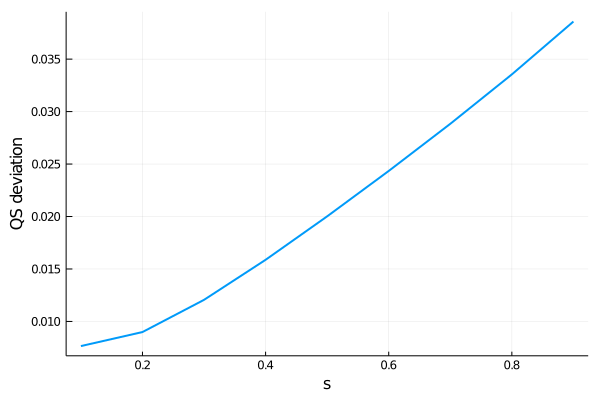

In [32]:
mqs = 1;
nqs = 4;
mb = 12;
nb = 12;
qsarray = Vector{Float64}(undef, 9)
for si in 1:9
    s = si/10;
    vmecSurface = VmecSurface(s, vmec);
    global qsarray[si] = quasisymmetry(mqs, nqs, mb, nb, vmecSurface)
end
plot(0.1:0.1:0.9, qsarray, linewidth=2, xaxis = "s", yaxis = "QS deviation",label="")
